In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import untils  # Provided utility
from COBWEBNN import CobwebNN, CobwebNNTreeLayer, TestModel
from torchvision import datasets, transforms
from encoder_decoder.resnet_encoder import Encoder, BasicBlockEnc
from encoder_decoder.restnet_decoder import Decoder, BasicBlockDec
from classes.resnet_using_light_basic_block_encoder import LightEncoder, LightBasicBlockEnc
from classes.resnet_using_light_basic_block_decoder import LightDecoder, LightBasicBlockDec
import matplotlib.pyplot as plt
import numpy as np
from classes.resnet_autoencoder import AE

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# test cuda
x = torch.tensor([1, 2, 3]).to(device)

In [5]:
train_loader, test_loader, train_data, test_data = untils.get_data_loader('cifar-10', 128, False)

In [24]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder(BasicBlockEnc, [2, 2, 2, 2])
        self.decoder = Decoder(BasicBlockDec, [2, 2, 2, 2])
        # self.encoder = LightEncoder(LightBasicBlockEnc, [2, 2, 2]) 
                # resnet 18 decoder
        # self.decoder = LightDecoder(LightBasicBlockDec, [2, 2, 2]) 

        # self.fc_encoder = nn.Linear(64*8*8, 512)
        # self.fc_decoder = nn.Linear(512, 64*8*8)
        # decoder MLP
        # self.decoder = nn.Sequential(
        #     nn.Linear(512, 64*2*2),
        #     nn.ReLU(True),
        #     nn.Linear(64*2*2, 64*4*4),
        #     nn.ReLU(True),
        #     nn.Linear(64*4*4, 3*32*32),
        #     nn.ReLU(True)
        # )

        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.ConTrans2d = nn.ConvTranspose2d(64, 64, 8, 8)

    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        # x = self.avgpool(x).view(x.size(0), -1)
        # x = x.view(x.size(0), -1)
        # x = self.fc_encoder(x)
        # print(x.shape)
        # x = self.fc_decoder(x).view(x.size(0), 64, 8, 8)

        # x = self.ConTrans2d(x)
        # print(x.shape)
        # x = self.fc_decoder(x)
        # x = x.view(x.size(0), 64, 8, 8)
        x = self.decoder(x)#.view(x.size(0), 3, 32, 32)
        # print(x.shape)
        return x

In [25]:
def visualize_reconstruction(model, test_data, n_data=64, device='cuda', epochs=100):
    model.eval()
    test_loader = DataLoader(test_data, batch_size=n_data, shuffle=True)
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(device)
            x_recon = model(x)
            break
    model.train()
    # untils.visualize(x, x_recon, n_data)
    # 8*8 subplots
    fig, axs = plt.subplots(8, 8, figsize=(16, 16))
    for i in range(8):
        for j in range(8):
            axs[i, j].imshow(x_recon[i*8+j].cpu().permute(1, 2, 0))
            axs[i, j].axis('off')
    # plt.show()
    # save image to file
    plt.savefig(f'./ae_out/ae_recon_{epochs}.png')
    

100%|██████████| 391/391 [00:24<00:00, 15.70it/s]


Epoch 0, Loss: 0.034484513103961945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.33222845..1.0056881].


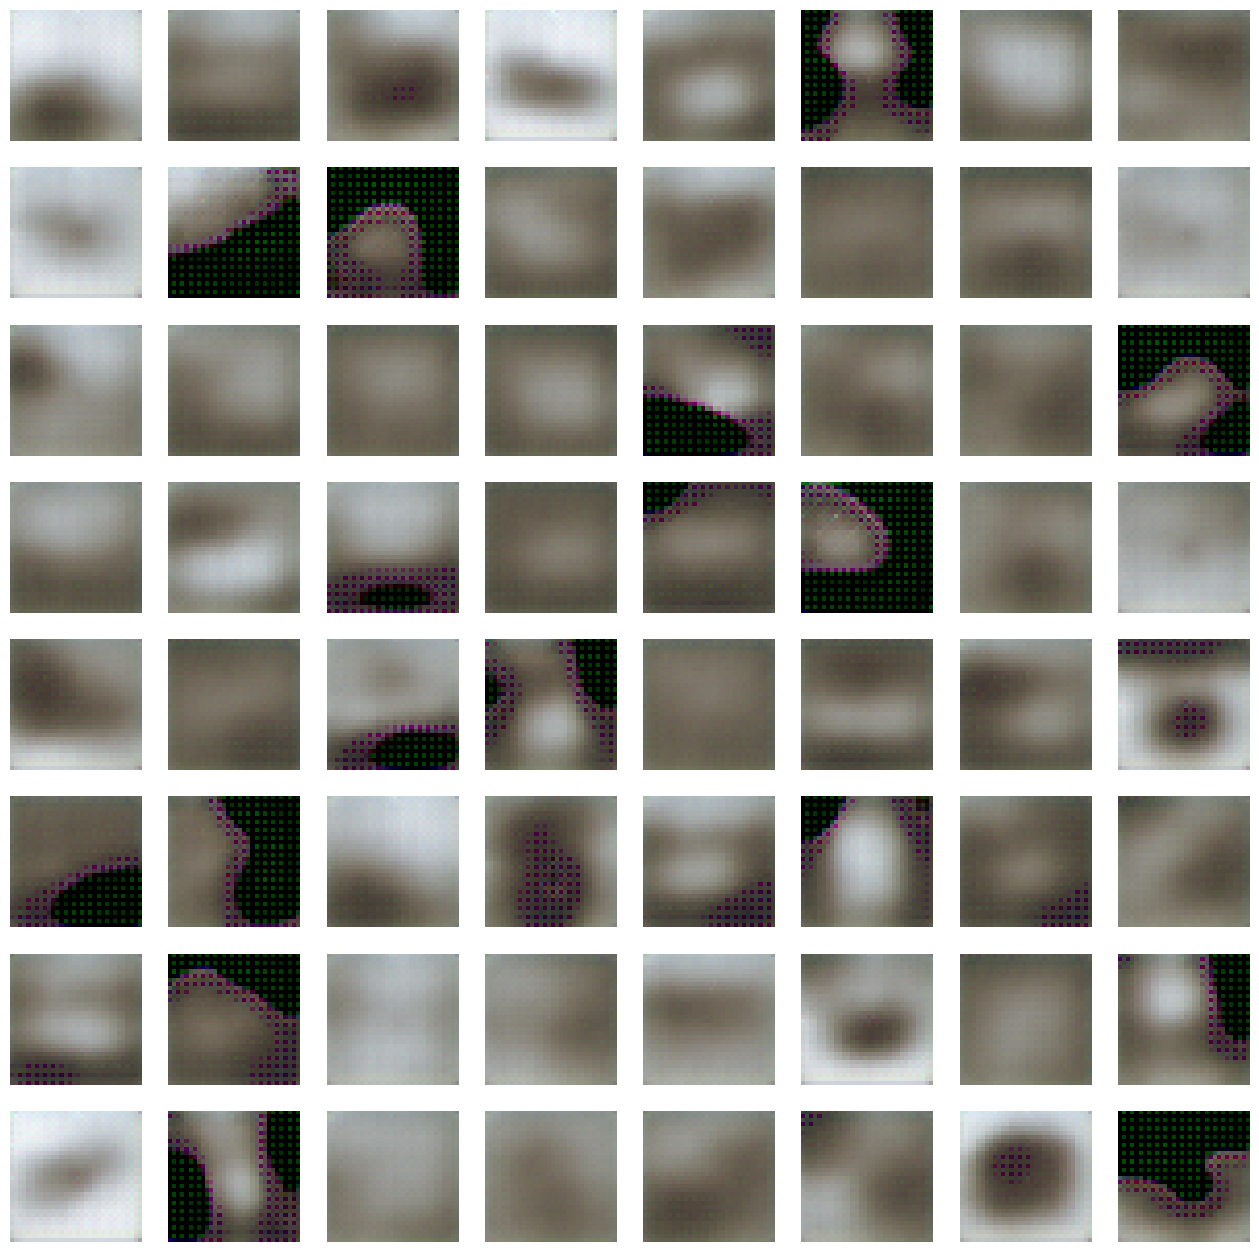

In [27]:
# train and test the model
model = AE().to(device)
# .to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

n_epochs = 1
loss_fn = nn.MSELoss()
for epoch in range(n_epochs):
    model.train()
    for i, (x, _) in enumerate(tqdm(train_loader)):
        x = x.to(device)
        # print(x.min(), x.max())
        optimizer.zero_grad()
        x_recon = model(x)
        # print(x_recon.min(), x_recon.max())
        # break
        loss = loss_fn(x_recon, x)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')
    if epoch % 10 == 0:
        visualize_reconstruction(model, test_data, 64, device, epoch)